# Experiments on real datasets 

Including preprocessing of data and comparison of different models with different metrics.

#### Datsets used
1. [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))
    - 569 samples (no missing values),
    - 30 features (removed 9 features with correlation > 0.9), 
    - 2 classes
    - 357 benign, 212 malignant
2. [Tic Tac Toe endgame Data Set](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame)
    - 958 samples (no missing values)
    - 9 features (no features with correlation > 0.9),
    - 2 classes

#### Metrics used
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Bootstrap accuracy

#### Models used
4. KNN - K-Nearest Neighbors
2. LDA - Linear Discriminant Analysis
1. Logistic Regression
5. Logistic Regression with IRLS (our model)
3. QDA - Quadratic Discriminant Analysis

## Dataset 1 - Breast Cancer

Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

In [1]:
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(return_X_y=True)

## Preparing data

In [2]:
from sklearn.preprocessing import OneHotEncoder
from collinearity import SelectNonCollinear
from sklearn.preprocessing import StandardScaler
import numpy as np

def remove_missing_rows(X, Y):
    mask = np.isnan(X).sum(axis=1) == 0
    return X[mask], Y[mask]

def encode_categorical(X):
    mask = np.array([isinstance(x, str) for x in X[0]])
    if mask.sum() > 0:    
        X = X[:, mask]
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X)
        X = enc.transform(X).toarray()
    return X

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X, columns_selection   

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [3]:
print(f"In the raw data, there are {X.shape[0]} observations and {X.shape[1]} features.")

In the raw data, there are 569 observations and 30 features.


Dropping rows with missing values, encoding categorical variables, dropping features with correlation > 0.9, and scaling the data.

In [4]:
X, Y = remove_missing_rows(X, Y)
X = encode_categorical(X)
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [5]:
print(f"In the prepared data, there are {X.shape[0]} observations and {X.shape[1]} features (removed {len(columns_selection) - np.array(columns_selection).sum()} features).")

In the prepared data, there are 569 observations and 21 features (removed 9 features).


### Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Models and metrics

In [7]:
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

class LRWrapper(LR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit(self, X, Y):
        X = pd.DataFrame(X)
        Y = Y.reshape(-1, 1)
        super().fit(X, Y)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        Y = super().predict(X)
        return Y

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic Regression': LogisticRegression,
        'Logistic Regression IRLS': partial(LRWrapper, maximisation_minorisation=True),
        'KNN': KNeighborsClassifier}

In [8]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def metric_bootstrap(X, Y, model_class, n=10):
    model = model_class()
    error = 0
    lenght_of_y = 0
    for i in range(n):
        sample_ids = resample(range(len(X)), replace=True, n_samples=len(X))

        test_ids = [i for i in range(len(X)) if i not in sample_ids]
        if len(sample_ids) == len(test_ids):
            i -= 1
            continue
        lenght_of_y += len(test_ids)
        train_ids = [i for i in range(len(X)) if i in sample_ids]
        model.fit(X[train_ids], Y[train_ids])
        y_pred = model.predict(X[test_ids])
        for i in range(len(y_pred)):
            if Y[test_ids[i]] != y_pred[i]:
                error += 1
    error_bootstrap = error / lenght_of_y
    accuracy_bootstrap = 1 - error_bootstrap
    return accuracy_bootstrap

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score,
            'bootstrap': metric_bootstrap}

## Experiments

Test run.

In [9]:
import pandas as pd
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X_train, Y_train, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.2)
df

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.927711,1.000000,0.947368,0.962500,0.947923
1,QDA,0.974359,0.987013,0.973684,0.980645,0.943687
2,Logistic Regression,0.915663,0.987013,0.929825,0.950000,0.927718
3,Logistic Regression IRLS,0.974359,0.987013,0.973684,0.980645,0.960237
4,KNN,0.901235,0.948052,0.894737,0.924051,0.892899


Repeated 10 times to create boxplots.

In [10]:
from tqdm import tqdm

test_size = 0.6 # it is this high to see differences in the results

df_list = []
for i in tqdm(range(50)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


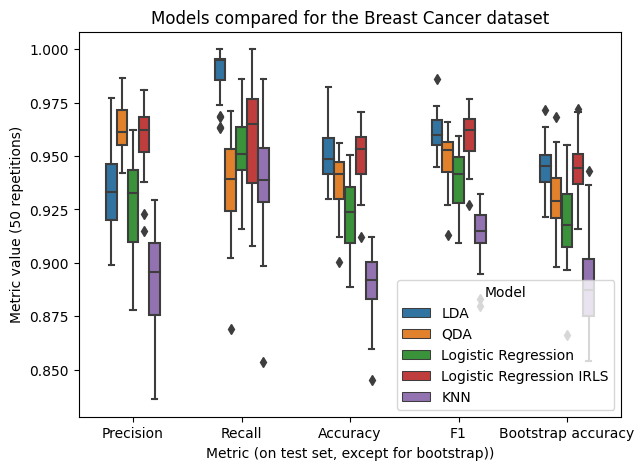

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the Breast Cancer dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel('Metric value (50 repetitions)')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_1_breast_cancer.png', dpi=300)
plt.show()

## Dataset 2 - Tic Tac Toe

Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame)

In [12]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data

--2023-04-11 12:44:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25866 (25K) [application/x-httpd-php]
Saving to: ‘tic-tac-toe.data.6’

tic-tac-toe.data.6  100%[===================>]  25.26K   122KB/s    in 0.2s    

2023-04-11 12:44:52 (122 KB/s) - ‘tic-tac-toe.data.6’ saved [25866/25866]



In [13]:
import pandas as pd

df = pd.read_csv('tic-tac-toe.data', header=None)
df.columns = ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'class']
df.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [14]:
X, Y = df.drop('class', axis=1).to_numpy(), df['class'].to_numpy()

## Preparing data

In [15]:
from collinearity import SelectNonCollinear
import numpy as np


def remove_missing_rows(X, Y):
    mask = np.isnan(X).sum(axis=1) == 0
    return X[mask], Y[mask]

def encode_state_to_numbers(X):
    # replace 'x' with -1, 'b' with 0 and 'o' with 1
    X = np.where(X == 'x', -1, X)
    X = np.where(X == 'b', 0, X)
    X = np.where(X == 'o', 1, X)
    return X.astype(int)

def class_to_numbers(Y):
    Y = np.where(Y == 'negative', 0, Y)
    Y = np.where(Y == 'positive', 1, Y)
    return Y.astype(int)

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X.astype(int), columns_selection

Before preparation:

In [16]:
print('Before processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
print(X[0], Y[0])
print(X[-1], Y[-1])

Before processing: rows:  958 columns:  9
['x' 'x' 'x' 'x' 'o' 'o' 'x' 'o' 'o'] positive
['o' 'o' 'x' 'x' 'x' 'o' 'o' 'x' 'x'] negative


Replace text with numbers.

In [17]:
X = encode_state_to_numbers(X)
Y = class_to_numbers(Y)
X, Y = remove_missing_rows(X, Y)
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [18]:
print('After processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
print(X[0], Y[0])
print(X[-1], Y[-1])

After processing: rows:  958 columns:  9
[-1 -1 -1 -1  1  1 -1  1  1] 1
[ 1  1 -1 -1 -1  1  1 -1 -1] 0


### Train/Test Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Models and metrics

In [20]:
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

class LRWrapper(LR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit(self, X, Y):
        X = pd.DataFrame(X)
        Y = Y.reshape(-1, 1)
        super().fit(X, Y)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        Y = super().predict(X)
        return Y

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic Regression': LogisticRegression,
        'Logistic Regression IRLS': partial(LRWrapper, maximisation_minorisation=True),
        'KNN': KNeighborsClassifier}

In [21]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def metric_bootstrap(X, Y, model_class, n=10):
    model = model_class()
    error = 0
    lenght_of_y = 0
    for i in range(n):
        sample_ids = resample(range(len(X)), replace=True, n_samples=len(X))

        test_ids = [i for i in range(len(X)) if i not in sample_ids]
        if len(sample_ids) == len(test_ids):
            i -= 1
            continue
        lenght_of_y += len(test_ids)
        train_ids = [i for i in range(len(X)) if i in sample_ids]
        model.fit(X[train_ids], Y[train_ids])
        y_pred = model.predict(X[test_ids])
        for i in range(len(y_pred)):
            if Y[test_ids[i]] != y_pred[i]:
                error += 1
    error_bootstrap = error / lenght_of_y
    accuracy_bootstrap = 1 - error_bootstrap
    return accuracy_bootstrap

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score,
            'bootstrap': metric_bootstrap}

## Experiments

Test run.

In [22]:
import pandas as pd
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X_train, Y_train, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.9)
df

/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/thispc/Data/ub_programs/python_venvs/aml/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/thispc/Data/ub_programs/pytho

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.974138,1.000000,0.982619,0.986900,0.899135
1,QDA,0.974138,1.000000,0.982619,0.986900,0.986595
2,Logistic Regression,0.826230,0.892035,0.806489,0.857872,0.796196
3,Logistic Regression IRLS,0.974138,1.000000,0.982619,0.986900,0.985955
4,KNN,0.860197,0.925664,0.852839,0.891731,0.747126


Repeated 10 times to create boxplots.

In [23]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

test_size = 0.85 # it is this high to see differences in the results

df_list = []
for i in tqdm(range(50)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


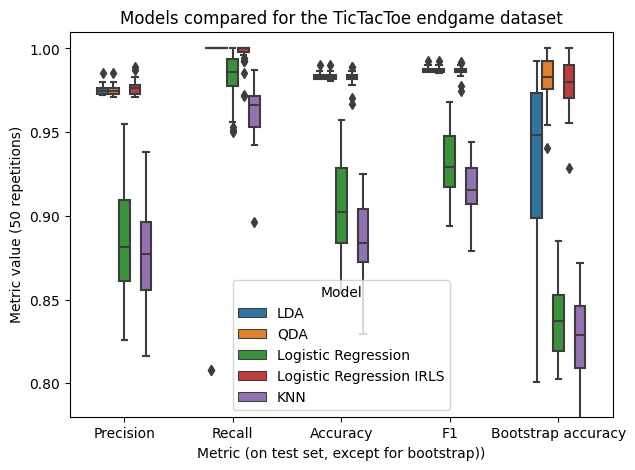

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the TicTacToe endgame dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel('Metric value (50 repetitions)')
ax.set_ylim(0.78, 1.01)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_2_tictactoe.png', dpi=300)
plt.show()